In [1]:
# from ucimlrepo import fetch_ucirepo (for direct fetching from database)
  
# # fetch dataset 
# student_performance = fetch_ucirepo(id=320) 
  
# # data (as pandas dataframes) 
# X = student_performance.data.features 
# y = student_performance.data.targets 
  
# # metadata 
# print(student_performance.metadata) 
  
# # variable information 
# print(student_performance.variables) 

In [2]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('student-por.csv', delimiter=';')

# Display the first few rows of the dataframe to understand its structure
df.sample(3)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
363,GP,F,18,U,GT3,T,3,4,other,other,...,5,4,4,1,1,1,4,11,12,14
156,GP,F,15,U,GT3,T,1,1,other,services,...,4,4,2,1,2,5,0,12,12,12
349,GP,F,17,U,GT3,T,3,2,health,health,...,5,2,2,1,2,5,0,18,18,18


In [3]:
# Assumption checks on G3 score normality

# Checking if G3 scores were normally distributed
from scipy.stats import shapiro

# Shapiro-Wilk test for normality on the non-zero G3 scores
stat, p = shapiro(df['G3'])

# Printing the test statistic and p-value
print(f'Statistic: {stat}, P-value: {p}')

# Checking the p-value and making a conclusion
if p > 0.05:
    print("The data follows a normal distribution.")
else:
    print("The data does not follow a normal distribution.")

Statistic: 0.9259835481643677, P-value: 2.4177243570922494e-17
The data does not follow a normal distribution.


In [4]:
# Trim rows with zeros in G3 column to achieve normality of G3 distribution
df_trimmed = df[df['G3'] > 0]
df_trimmed.to_csv('student-por-trimmed.csv', index=False)

# Counting the number of rows with zero G3 scores that were dropped
num_rows_dropped = df[df['G3'] == 0].shape[0]

# Counting the number of rows retained for analyses after dropping zero G3 scores
num_rows_retained = df_trimmed.shape[0]

(num_rows_dropped, num_rows_retained)

(15, 634)

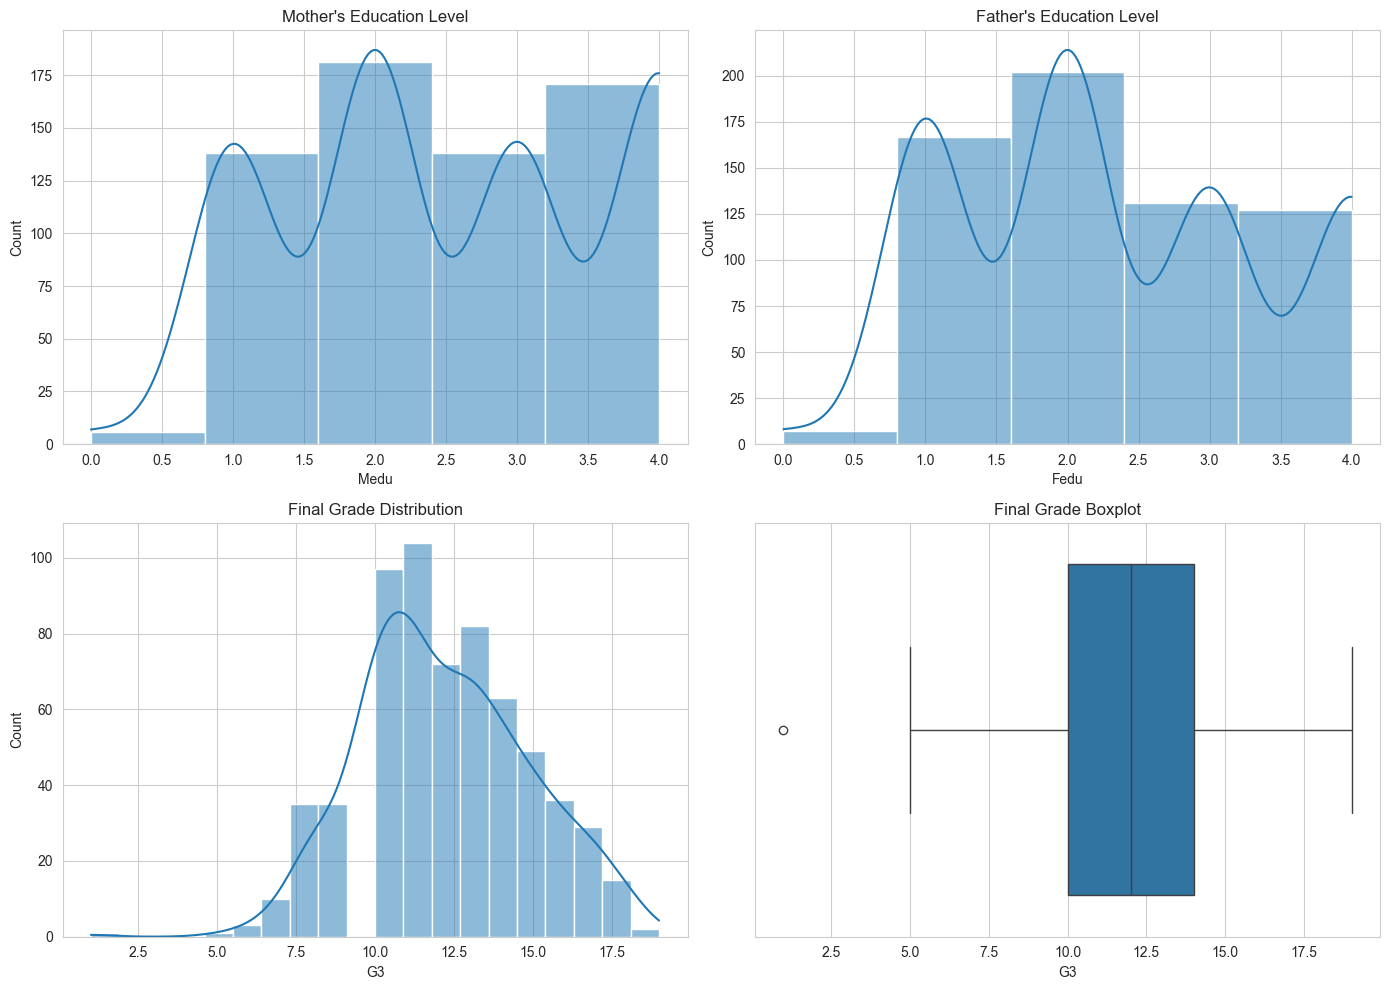

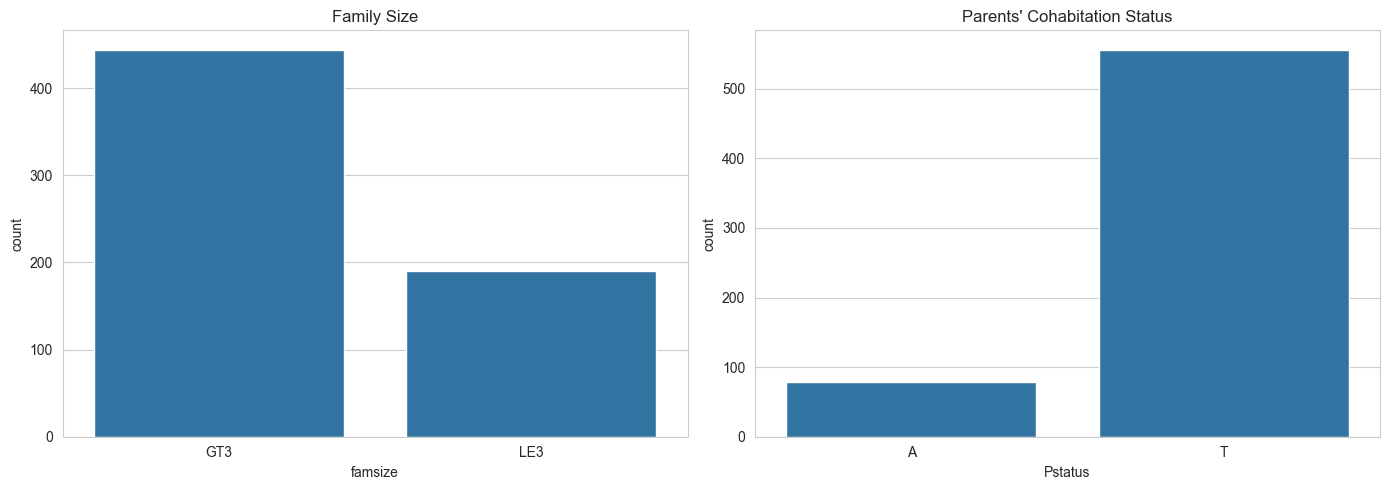

In [5]:
# Family background influence G3 grades?
# exploratory data visualisation

import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetics for the plots
sns.set_style("whitegrid")

# Plot distributions of parent's education level and final grade
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
sns.histplot(data=df_trimmed, x="Medu", bins=5, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Mother's Education Level")
sns.histplot(data=df_trimmed, x="Fedu", bins=5, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Father's Education Level")
sns.histplot(data=df_trimmed, x="G3", bins=20, kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Final Grade Distribution")
sns.boxplot(data=df_trimmed, x='G3', ax=axes[1, 1])
axes[1, 1].set_title("Final Grade Boxplot")

plt.tight_layout()
plt.show()

# Count plots for categorical variables
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.countplot(data=df_trimmed, x="famsize", ax=axes[0])
axes[0].set_title("Family Size")
sns.countplot(data=df_trimmed, x="Pstatus", ax=axes[1])
axes[1].set_title("Parents' Cohabitation Status")

plt.tight_layout()
plt.show()

In [24]:
# compute proportions of Medu and Fedu level 3 or higher

medu_at_least_3 = (df_trimmed['Medu'] >= 3).mean()
fedu_at_least_3 = (df_trimmed['Fedu'] >= 3).mean()

print(f"Proportion of mothers with at least level 3 education: {medu_at_least_3:.3f}")
print(f"Proportion of fathers with at least level 3 education: {fedu_at_least_3:.3f}")

Proportion of mothers with at least level 3 education: 0.487
Proportion of fathers with at least level 3 education: 0.407


In [25]:
# compute proportions of famsize LE3 and Pstatus T

prop_gt3 = (df_trimmed['famsize'] == 'GT3').mean()
prop_parents_together = (df_trimmed['Pstatus'] == 'T').mean()

print(f"Proportion of families with more than 3 members: {prop_gt3:.3f}")
print(f"Proportion of parents living together: {prop_parents_together:.3f}")

Proportion of families with more than 3 members: 0.700
Proportion of parents living together: 0.877


In [6]:
#check for multicollinearity

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import shapiro
import statsmodels.api as sm
import numpy as np

# Prepare the data with dummy variables for categorical predictors
data_prep = pd.get_dummies(df_trimmed, columns=['famsize', 'Pstatus'], drop_first=True)

# Checking for multicollinearity using VIF (Variance Inflation Factor)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Predictors for the model
predictors_fam = ['Medu', 'Fedu', 'famsize_LE3', 'Pstatus_T']

# Add a constant for the intercept
X = sm.add_constant(data_prep[predictors_fam])
y = data_prep['G3']

X['famsize_LE3'] = X['famsize_LE3'].astype(int)
X['Pstatus_T'] = X['Pstatus_T'].astype(int)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# Display VIFs
vif_data

,feature,VIF
0,const,16.638494
1,Medu,1.722081
2,Fedu,1.721765
3,famsize_LE3,1.062694
4,Pstatus_T,1.063858


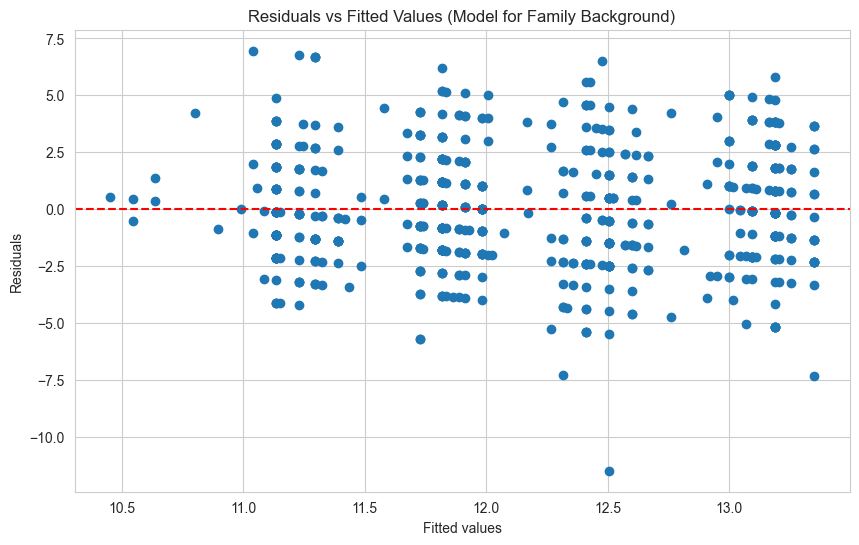

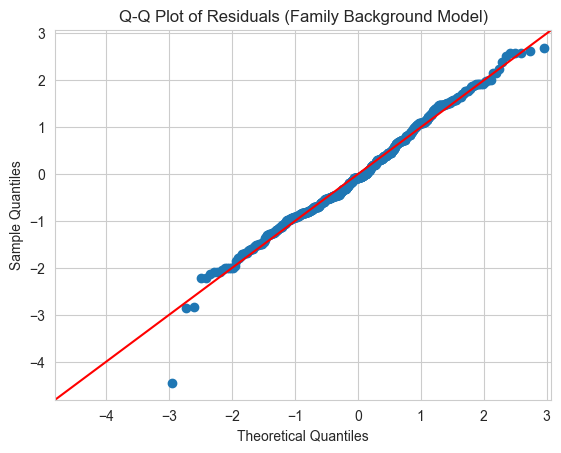

Goldfeld-Quandt Test: Evidence of heteroscedasticity (p-value = 0.002401637282541328).
Breusch-Pagan Test: No evidence of heteroscedasticity (p-value = 0.18490294054396567).


In [7]:
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms

# Fitting the comprehensive multiple linear regression model
model_fam = sm.OLS(y, X).fit()

# Homoscedasticity test using residuals plot
plt.figure(figsize=(10, 6))
plt.scatter(model_fam.fittedvalues, model_fam.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (Model for Family Background)')
plt.show()

# Normality of errors test using Q-Q plot
fig = sm.qqplot(model_fam.resid, fit=True, line='45')
plt.title('Q-Q Plot of Residuals (Family Background Model)')
plt.show()

# Conducting homoscedasticity tests for the comprehensive model
gq_test_family = sms.het_goldfeldquandt(model_fam.resid, model_fam.model.exog)
bp_test_family = sms.het_breuschpagan(model_fam.resid, model_fam.model.exog)

if gq_test_family[1] < 0.05:
    print(f"Goldfeld-Quandt Test: Evidence of heteroscedasticity (p-value = {gq_test_family[1]}).")
else:
    print(f"Goldfeld-Quandt Test: No evidence of heteroscedasticity (p-value = {gq_test_family[1]}).")

if bp_test_family[1] < 0.05:
    print(f"Breusch-Pagan Test: Evidence of heteroscedasticity (p-value = {bp_test_family[1]}).")
else:
    print(f"Breusch-Pagan Test: No evidence of heteroscedasticity (p-value = {bp_test_family[1]}).")

In [8]:
# Re-estimating the family model with robust standard errors
model_fam_robust = model_fam.get_robustcov_results(cov_type='HC3')

# Summary of the model with robust standard errors
model_fam_robust_summary = model_fam_robust.summary()
model_fam_robust_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     13.83
Date:                Mon, 18 Mar 2024   Prob (F-statistic):           8.16e-11
Time:                        00:28:37   Log-Likelihood:                -1502.0
No. Observations:                 634   AIC:                             3014.
Df Residuals:                     629   BIC:                             3036.
Df Model:                           4                                         
Covariance Type:                  HC3                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          10.3042      0.408     25.279      0.000       9.504      11.105
Medu            0.5908      0.125      4.726      0.000       0.345       0.836
Fedu            0.0942      0.135      0.700      0.484      -0.170       0.358
famsize_LE3     0.1611      0.230      0.700      0.484      -0.291       0.613
Pstatus_T       0.1454      0.319      0.456      0.648      -0.480       0.771
==============================================================================
Omnibus:                        1.564   Durbin-Watson:                   1.583
Prob(Omnibus):                  0.457   Jarque-Bera (JB):                1.406
Skew:                           0.063   Prob(JB):                        0.495
Kurtosis:                       3.193   Cond. No.                         19.3
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Preparing data: Encoding categorical variables and selecting features
predictors_list = ['age', 'studytime', 'traveltime', 'freetime', 'Dalc', 'Walc', 
                   'Medu', 'Fedu', 'famrel', 'failures', 'G1']

# Encoding 'sex', 'schoolsup', and 'famsup' as they are binary categorical variables
data_comprehensive = pd.get_dummies(df_trimmed, columns=['sex', 'schoolsup', 'famsup'], drop_first=True)

predictors_list += ['sex_M', 'schoolsup_yes', 'famsup_yes']

# Selecting predictors and adding a constant for the intercept
X_comprehensive = sm.add_constant(data_comprehensive[predictors_list])
y_comprehensive = data_comprehensive['G3']

X_comprehensive['sex_M'] = X_comprehensive['sex_M'].astype(int)
X_comprehensive['schoolsup_yes'] = X_comprehensive['schoolsup_yes'].astype(int)
X_comprehensive['famsup_yes'] = X_comprehensive['famsup_yes'].astype(int)

# Checking for multicollinearity using VIF
vif_data_comprehensive = pd.DataFrame()
vif_data_comprehensive["feature"] = X_comprehensive.columns
vif_data_comprehensive["VIF"] = [variance_inflation_factor(X_comprehensive.values, i) for i in range(len(X_comprehensive.columns))]

vif_data_comprehensive

,feature,VIF
0,const,305.880145
1,age,1.195561
2,studytime,1.158143
3,traveltime,1.101992
4,freetime,1.061555
5,Dalc,1.724369
6,Walc,1.774553
7,Medu,1.880999
8,Fedu,1.768217
9,famrel,1.048066


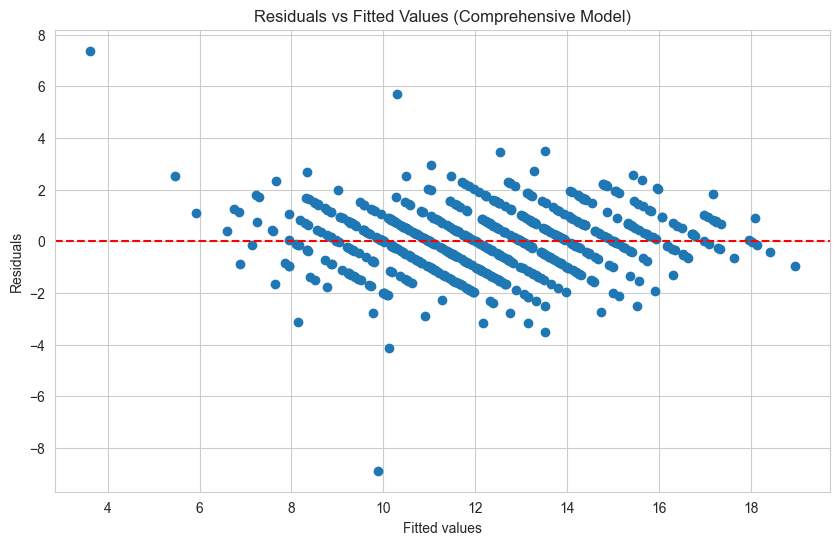

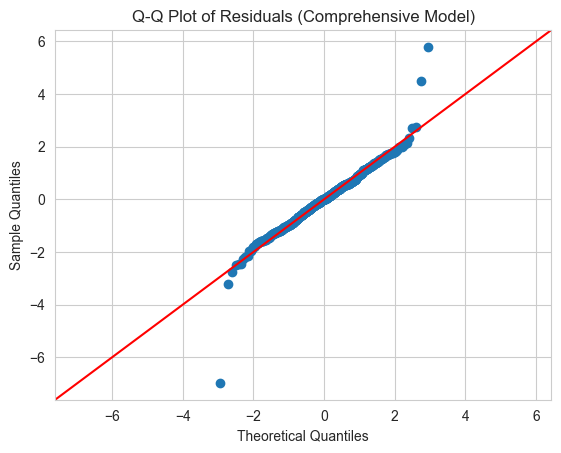

Goldfeld-Quandt Test: No evidence of heteroscedasticity (p-value = 0.9963282219385281).
Breusch-Pagan Test: No evidence of heteroscedasticity (p-value = 0.13785249453891046).


In [10]:
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms

# Fitting the comprehensive multiple linear regression model
model_comprehensive = sm.OLS(y_comprehensive, X_comprehensive).fit()

# Homoscedasticity test using residuals plot
plt.figure(figsize=(10, 6))
plt.scatter(model_comprehensive.fittedvalues, model_comprehensive.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (Comprehensive Model)')
plt.show()

# Normality of errors test using Q-Q plot
fig = sm.qqplot(model_comprehensive.resid, fit=True, line='45')
plt.title('Q-Q Plot of Residuals (Comprehensive Model)')
plt.show()

# Conducting homoscedasticity tests for the comprehensive model
gq_test_comprehensive = sms.het_goldfeldquandt(model_comprehensive.resid, model_comprehensive.model.exog)
bp_test_comprehensive = sms.het_breuschpagan(model_comprehensive.resid, model_comprehensive.model.exog)

if gq_test_comprehensive[1] < 0.05:
    print(f"Goldfeld-Quandt Test: Evidence of heteroscedasticity (p-value = {gq_test_comprehensive[1]}).")
else:
    print(f"Goldfeld-Quandt Test: No evidence of heteroscedasticity (p-value = {gq_test_comprehensive[1]}).")

if bp_test_comprehensive[1] < 0.05:
    print(f"Breusch-Pagan Test: Evidence of heteroscedasticity (p-value = {bp_test_comprehensive[1]}).")
else:
    print(f"Breusch-Pagan Test: No evidence of heteroscedasticity (p-value = {bp_test_comprehensive[1]}).")


In [11]:
# Re-estimating the comprehensive model with robust standard errors
model_comprehensive_robust = model_comprehensive.get_robustcov_results(cov_type='HC3')

# Summary of the model with robust standard errors
model_comprehensive_robust_summary = model_comprehensive_robust.summary()
model_comprehensive_robust_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     146.1
Date:                Mon, 18 Mar 2024   Prob (F-statistic):          1.60e-185
Time:                        00:28:38   Log-Likelihood:                -1053.0
No. Observations:                 634   AIC:                             2136.
Df Residuals:                     619   BIC:                             2203.
Df Model:                          14                                         
Covariance Type:                  HC3                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.8090      0.849     -2.131      0.033      -3.476      -0.142
age               0.2609      0.049      5.311      0.000       0.164       0.357
studytime         0.0353      0.062      0.572      0.567      -0.086       0.156
traveltime        0.1027      0.082      1.247      0.213      -0.059       0.264
freetime         -0.0605      0.051     -1.181      0.238      -0.161       0.040
Dalc             -0.0941      0.093     -1.017      0.310      -0.276       0.088
Walc             -0.0594      0.051     -1.174      0.241      -0.159       0.040
Medu              0.1435      0.064      2.227      0.026       0.017       0.270
Fedu              0.0029      0.064      0.045      0.964      -0.123       0.129
famrel            0.0783      0.053      1.463      0.144      -0.027       0.183
failures         -0.4365      0.126     -3.453      0.001      -0.685      -0.188
G1                0.8185      0.035     23.504      0.000       0.750       0.887
sex_M            -0.1647      0.120     -1.368      0.172      -0.401       0.072
schoolsup_yes    -0.1007      0.199     -0.507      0.613      -0.491       0.290
famsup_yes       -0.0773      0.118     -0.657      0.511      -0.308       0.154
==============================================================================
Omnibus:                       82.703   Durbin-Watson:                   1.640
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              732.300
Skew:                          -0.146   Prob(JB):                    9.62e-160
Kurtosis:                       8.257   Cond. No.                         379.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Features and target variable
X_ml = data_comprehensive[predictors_list]  # Using the predictors list from the comprehensive model
y_ml = data_comprehensive['G3']

# Splitting the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_ml, y_ml, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predicting on the test set
y_pred = lr_model.predict(X_test_scaled)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Printing interpretations
print(f"Mean Squared Error (MSE): {mse:.2f}")
print("Interpretation: Represents the average squared difference between the estimated values and the actual value. A lower MSE indicates better fit.")
print(f"R-squared (R²): {r2:.2f}")
print("Interpretation: Represents the proportion of the variance for the dependent variable that's explained by the independent variables in the model. R² = 1 indicates a perfect fit.")

Mean Squared Error (MSE): 1.81
Interpretation: Represents the average squared difference between the estimated values and the actual value. A lower MSE indicates better fit.
R-squared (R²): 0.78
Interpretation: Represents the proportion of the variance for the dependent variable that's explained by the independent variables in the model. R² = 1 indicates a perfect fit.


In [13]:
# Adding 'absences' and 'goout' to our list of predictors
adjusted_predictors_list = predictors_list + ['absences', 'goout']

# Creating an interaction term between 'studytime' and 'health'
data_comprehensive['studytime_health_interaction'] = data_comprehensive['studytime'] * data_comprehensive['health']

# Adding the interaction term to our predictors list
adjusted_predictors_list.append('studytime_health_interaction')

# Preparing the adjusted dataset for the model
X_ml_adjusted = data_comprehensive[adjusted_predictors_list]

# Splitting the adjusted dataset into training and test sets
X_train_adjusted, X_test_adjusted, y_train_adjusted, y_test_adjusted = train_test_split(X_ml_adjusted, y_ml, test_size=0.2, random_state=42)

# Standardizing the adjusted features
X_train_adjusted_scaled = scaler.fit_transform(X_train_adjusted)
X_test_adjusted_scaled = scaler.transform(X_test_adjusted)

# Re-training the Linear Regression model with the adjusted features
lr_model_adjusted = LinearRegression()
lr_model_adjusted.fit(X_train_adjusted_scaled, y_train_adjusted)

# Predicting on the test set with the adjusted model
y_pred_adjusted = lr_model_adjusted.predict(X_test_adjusted_scaled)

# Evaluating the adjusted model
mse_adjusted = mean_squared_error(y_test_adjusted, y_pred_adjusted)
r2_adjusted = r2_score(y_test_adjusted, y_pred_adjusted)

# Printing interpretations
print(f"Mean Squared Error (MSE): {mse_adjusted:.2f}")
print("Interpretation: Represents the average squared difference between the estimated values and the actual value. A lower MSE indicates better fit.")
print(f"R-squared (R²): {r2_adjusted:.2f}")
print("Interpretation: Represents the proportion of the variance for the dependent variable that's explained by the independent variables in the model. R² = 1 indicates a perfect fit.")

Mean Squared Error (MSE): 1.81
Interpretation: Represents the average squared difference between the estimated values and the actual value. A lower MSE indicates better fit.
R-squared (R²): 0.78
Interpretation: Represents the proportion of the variance for the dependent variable that's explained by the independent variables in the model. R² = 1 indicates a perfect fit.


In [14]:
from sklearn.ensemble import RandomForestRegressor

# Training the Random Forest Regression model with the adjusted features
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_adjusted_scaled, y_train_adjusted)

# Predicting on the test set with the Random Forest model
y_pred_rf = rf_model.predict(X_test_adjusted_scaled)

# Evaluating the Random Forest model
mse_rf = mean_squared_error(y_test_adjusted, y_pred_rf)
r2_rf = r2_score(y_test_adjusted, y_pred_rf)

# Printing interpretations
print(f"Mean Squared Error (MSE): {mse_rf:.2f}")
print("Interpretation: Represents the average squared difference between the estimated values and the actual value. A lower MSE indicates better fit.")
print(f"R-squared (R²): {r2_rf:.2f}")
print("Interpretation: Represents the proportion of the variance for the dependent variable that's explained by the independent variables in the model. R² = 1 indicates a perfect fit.")

Mean Squared Error (MSE): 2.09
Interpretation: Represents the average squared difference between the estimated values and the actual value. A lower MSE indicates better fit.
R-squared (R²): 0.75
Interpretation: Represents the proportion of the variance for the dependent variable that's explained by the independent variables in the model. R² = 1 indicates a perfect fit.


In [15]:
from sklearn.model_selection import GridSearchCV

# Setting up the parameter grid for basic tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
}

# Setting up the GridSearchCV object
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), 
                           param_grid=param_grid, 
                           cv=5,  # 5-fold cross-validation
                           scoring='neg_mean_squared_error', 
                           n_jobs=-1,  # Use all available cores
                           verbose=1)

# Fitting the grid search to the data
grid_search.fit(X_train_adjusted_scaled, y_train_adjusted)

# Best parameters and best score (MSE)
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # Negating to turn back into MSE

(best_params, best_score)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


({'max_depth': None, 'n_estimators': 200}, 1.7645408003300331)

In [16]:
# Re-train random forest regressor with optimised hyperparameters

from sklearn.ensemble import RandomForestRegressor

# Using the best parameters from GridSearchCV to instantiate the model
best_max_depth = 20
best_n_estimators = 200

# Creating a new Random Forest Regressor with the optimal parameters
rf_model_optimized = RandomForestRegressor(max_depth=best_max_depth, n_estimators=best_n_estimators, random_state=42)

# Training the optimized model on the scaled training data
# Note: Make sure to use the same training data as before
rf_model_optimized.fit(X_train_scaled, y_train)

# Predicting on the test set with the optimized model
y_pred_optimized = rf_model_optimized.predict(X_test_scaled)

# Evaluating the optimized model
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
r2_optimized = r2_score(y_test, y_pred_optimized)

# Printing the evaluation metrics for the optimized model
print(f"Optimized Random Forest Mean Squared Error (MSE): {mse_optimized:.2f}")
print(f"Optimized Random Forest R-squared (R²): {r2_optimized:.2f}")

Optimized Random Forest Mean Squared Error (MSE): 1.98
Optimized Random Forest R-squared (R²): 0.76


In [17]:
from sklearn.ensemble import GradientBoostingRegressor

# Training the Gradient Boosting Regressor model with the adjusted features
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train_adjusted_scaled, y_train_adjusted)

# Predicting on the test set with the Gradient Boosting model
y_pred_gb = gb_model.predict(X_test_adjusted_scaled)

# Evaluating the Gradient Boosting model
mse_gb = mean_squared_error(y_test_adjusted, y_pred_gb)
r2_gb = r2_score(y_test_adjusted, y_pred_gb)

# Printing the evaluation metrics for the optimized model
print(f"Gradient Boosting Regressor Mean Squared Error (MSE): {mse_gb:.2f}")
print(f"Gradient Boosting Regressor R-squared (R²): {r2_gb:.2f}")

Gradient Boosting Regressor Mean Squared Error (MSE): 1.95
Gradient Boosting Regressor R-squared (R²): 0.76
